# Discrete Policy Gradient

# Functions

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
def pi(state, theta, num_actions):
    logits = np.zeros(num_actions)
    for action in range(num_actions):
        logit = np.exp(theta[state, action])
        logits[action] = logit
        
    return logits / np.sum(logits)

In [3]:
def update_policy(ep_states, ep_actions, ep_probs, ep_returns, theta, alpha, num_actions):
    
    for t in range(0,len(ep_states)):
        state = ep_states[t]
        action = ep_actions[t]
        prob = ep_probs[t]
        action_return = ep_returns[t]

        phi = np.zeros([1, num_actions])
        phi[0, action] = 1
 
        score = phi - prob
        theta[state, :] = theta[state, :] + alpha * action_return * score

    return theta

In [4]:
def calc_return(rewards, gamma):
    # https://stackoverflow.com/questions/65233426/discount-reward-in-reinforce-deep-reinforcement-learning-algorithm
    ep_rewards = np.asarray(rewards)
    t_steps = np.arange(ep_rewards.size)
    ep_returns = ep_rewards * gamma**t_steps
    ep_returns = ep_returns[::-1].cumsum()[::-1] / gamma**t_steps
    return ep_returns.tolist()

In [5]:
def theta_to_prob(theta):
    """transforms numerical matrix to probsability matrix"""
    rows = theta.shape[0]
    cols = theta.shape[1]
    probs = np.zeros((rows, cols))
    logits = np.zeros(cols)

    for state in range(rows):
        for action in range(cols):
            logit = np.exp(theta[state, action])
            logits[action] = logit
        probs[state] = logits / np.sum(logits)
    return probs

In [6]:
def policy_to_certanity(theta):
    """transforms policy matrix to certainty matrix"""
    probs = theta_to_prob(theta)
    rows = probs.shape[0]
    cols = probs.shape[1]
    certs = np.zeros((rows, cols), dtype = "f, f, f, f")
    
    for state in range(rows):
        for action in range(cols):
            p = probs[state, action]
            certs[state, action] = (p, 1-p, 0, p)
    return(certs)

In [7]:
def beliefConstraintFusion(matrix1, matrix2):
    rows = matrix1.shape[0]
    cols = matrix2.shape[1]
    fused = np.zeros((rows, cols), dtype = "f, f, f, f")
    for state in range(rows):
        for action in range(cols):
            b1 = (matrix1[state, action])[0]
            d1 = (matrix1[state, action])[1]
            u1 =  (matrix1[state, action])[2]
            a1 = (matrix1[state, action])[3]

            b2 = (matrix2[state, action])[0]
            d2 = (matrix2[state, action])[1]
            u2 =  (matrix2[state, action])[2]
            a2 = (matrix2[state, action])[3]

            harmony = b1*b2 + b1*u2 + b2*u1
            conflict = b1*d2 + b2*d1
            b = harmony / (1 - conflict)
            u = u1 * u2 / (1 - conflict)
            a = (a1 * (1 - u1) + a2 * (1 - u2)) / (2 - u1 - u2)
            d = 1 - (b + u)

            (fused[state, action])[0] = b
            (fused[state, action])[1] = d
            (fused[state, action])[2] = u
            (fused[state, action])[3] = a
    return fused

In [8]:
def cert_to_policy(certs):
    rows = certs.shape[0]
    cols = certs.shape[1]
    probs = np.zeros((rows, cols))
    for state in range(rows):
        for action in range(cols):
            b = (certs[state, action])[0]
            u = (certs[state, action])[2]
            a = (certs[state, action])[3]
            probs[state, action] = b + a * u

    # normalize probability matrix so each row sums to 1
    probs = normalize(probs, axis=1, norm='l1')

    theta = np.zeros((rows, cols))

    for state in range(rows):
        mu = probs[state]
        log_sum = 0 
        for action in range(cols):
            log_sum += np.log(mu[action])
        c = (-1 / cols) * log_sum

        for action in range(cols):
            theta[state, action] = np.log(mu[action]) + c

    return theta

In [19]:
def human_advice(num_states, num_actions):
    # create initialized theta matrix of zeros
    policy_num = np.zeros((num_states, num_actions))

    # 1a/2b convert policy from agent into a matrix of certainties
    policy_cert = policy_to_certanity(policy_num)

    # 1b capture human opinion 
    opinion = np.load('opinion.npy')

    # 2b fusion
    fused = beliefConstraintFusion(policy_cert, opinion)

    # 3 convert certainties to policy for agent 
    theta = cert_to_policy(fused)

    np.savetxt('human_advised_policy', theta, delimiter= ',')

In [20]:
def discrete_policy_grad(num_states, num_actions, map_size, MAX_EPISODES, slippery, alpha, gamma, advice):

    # train model using human advice if available
    if advice == True: 
        human_advice(num_states, num_actions)
        theta = np.loadtxt('human_advised_policy', delimiter=",")
    else: theta = np.zeros((num_states, num_actions))


    # train model using discrete policy grad
    env = gym.make('FrozenLake-v1', map_name = map_size, is_slippery = slippery)
    
    total_reward, total_successes = [], 0
    
    for episode in range(MAX_EPISODES):
        state = env.reset()[0]
        ep_states, ep_actions, ep_probs, ep_rewards, total_ep_rewards = [], [], [], [], 0
        terminated, truncated = False, False

        # gather trajectory
        while not terminated and not truncated:
            # add state to ep_states list
            ep_states.append(state)
            # pass state thru policy to get action_probs
            action_probs = pi(state, theta, num_actions)
            # add action probabilities to action_probs list
            ep_probs.append(action_probs)
            # choose an action
            action = np.random.choice(np.array([0, 1, 2, 3]), p = action_probs)
            # add action to ep_actions list
            ep_actions.append(action)
            # take step in environment
            state, reward, terminated, truncated, __ = env.step(action)
            # add reward to ep_rewards list
            ep_rewards.append(reward)
            total_ep_rewards += reward
            if reward == 1: total_successes += 1

        # calculate episode return & add total episode reward to totalReward
        ep_returns = calc_return(ep_rewards, gamma)
        total_reward.append(sum(ep_rewards))
            
        # update policy
        update_policy(ep_states, ep_actions, ep_probs, ep_returns, theta, alpha, num_actions)

    #np.savetxt('theta', theta, delimiter= ',')
    env.close()
    
    # evaluate model

    # success rate
    success_rate = (total_successes/MAX_EPISODES) * 100
    return success_rate
    #print(f"Success rate after {MAX_EPISODES} episodes = {success_rate}%")

    # graph of cumulative reward
    #cumulative_reward = np.cumsum(total_reward)
    #plt.plot(cumulative_reward)
    #plt.title('Cumulative reward per episode')
    #plt.xlabel('Episode')
    #plt.ylabel('Cumulative Reward')
    #plt.show()
        

In [11]:
def evaluate(experiments, MAX_EPISODES):
    no_advice_success_rates = []
    for i in range(experiments):
        iteration = discrete_policy_grad(num_states, num_actions, map_size, MAX_EPISODES, slippery, alpha, gamma, advice = False)
        no_advice_success_rates.append(iteration)

    advice_success_rates = []
    for i in range(experiments):
        iteration = discrete_policy_grad(num_states, num_actions, map_size, MAX_EPISODES, slippery, alpha, gamma, advice = True)
        advice_success_rates.append(iteration)

    plt.plot(no_advice_success_rates, label = 'No advice')
    plt.plot(advice_success_rates, label = 'Advice')
    plt.title('Training on ' + str(map_size) + ' map ' + 'for ' + str(MAX_EPISODES) + ' episodes ' + ', is_slippery = ' + str(slippery))
    plt.xlabel('Iteration')
    plt.ylabel('Success Rate %')
    plt.legend()
    plt.show()

# Evaluation

- export evaluation data as csv and open in pandas
- test that there is a difference in mean success rate with advice vs without advice (t-test)

## 4x4 Not Slippery

In [17]:
map_size = '4x4'; slippery = False; alpha = 0.9; gamma = 1
env = gym.make('FrozenLake-v1', map_name = map_size, is_slippery = slippery)
num_states = env.observation_space.n
num_actions = env.action_space.n

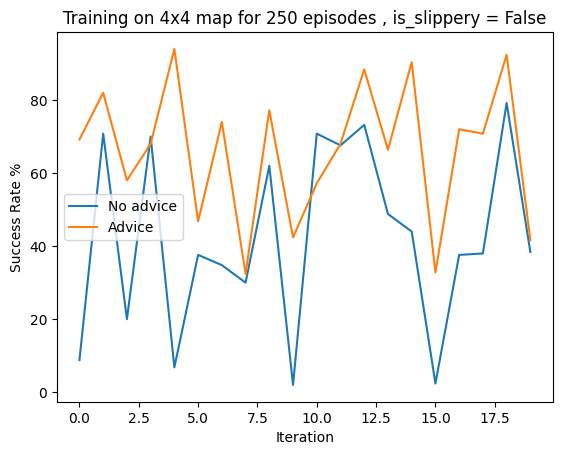

In [25]:
evaluate(experiments= 20, MAX_EPISODES= 250)